In [4]:
import numpy as np
import pandas as pd
import sklearn as skl
import ggplot as gg

In [40]:
# iForest v0.1
#
# rpatricktaylor@gmail.com
# https://www.github.com/rpatricktaylor
#
#
#
# MIT License
#
# Copyright (c) [2016] [Ryan Patrick Taylor]
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import numpy as np

class IsoRandForest:
    '''Random Forest ensemble used for isolating anomalies/outliers.
       This is an implementation of the iForest (Isolation Forest)
       algorithm by Liu et al [2008]

       Please note that is implementation is a proof of concept,
       meant to illustrate the usefulness of anomaly detection by
       randomly generated trees, NOT an optimized production-ready library.

    Parameters
    ----------
    n_trees: Int
        Number of trees to include in the ensemble
    max_depth: Int
        Maximum depth considered when building each random tree
    random_seed: Int
        Initial seed for random number generator (to allow for reproducable)
        results

    Attributes
    ----------
    anom_scores: List (floats)
        Anomaly scores for each observation (ranges between 0.5 and 1)
        Each anomaly score ranges between 0.5 and 1 with higher scores
        corresponding to points being more likely to be anomalous
    trees: List (IsoTrees)
        Random trees which comprise the ensemble
    c_n: Float
        Normalization factor for computing anomaly scores
    '''

    # Interface:
    #   get_parameters - Return a dict containing the parameters of the
    #                    IsoRandForest ensemble
    #   get_anomScores - Access the anomaly scores for all observations
    #   get_trees      - Access the IsoTrees comprising the ensemble
    #   fit            - Fit the model to a data set (NumPy array)
    #   anomaly_score  - Calculate the anomaly score for a given point
    #                    Note that the point used does not have to be in the
    #                    data set used to fit the model

    class IsoTree:
        '''IsoTree is (non-recombining) binary tree which serves as the
       primary data structure of the ensemble. The IsoRandForest classifier
       is comprised of a list of IsoTrees.
       Each node in an IsoTree consists of an axis along which a split
       is made and the location of the split. The complete tree encodes
       a partitioning of the original data into several hyper-rectangular
       regions.

       Parameters
       ----------
       maxDepth: Int
          The maximum allowable depth of the tree

       Attributes
       ----------
       root: IsoTreeNode
          The root node of the binary tree
          '''

       # Interface:
       #   fitTree   - Fit the tree to a data set (NumPy array)
       #   findDepth - Determine the depth at which a given point would
       #               be isolated by the splits encoded in the tree


        class IsoTreeNode:
            '''An IsoTreeNode represents a particular location in the IsoTree.
            Each node contains a column index for the split made at that
            location, as well as the location of the split.
            The left and right subtrees are given as further IsoTreeNodes if
            the stopping condition (maximum depth or isolation of a single point)
            has not been met. If the stopping condition has been met, the child
            node is given as a None value.

            Parameters
            ----------
            splitVar: Int
               Column index of the split represented by the node
            splitVal: Float
               Location of the split represented by the node

           Attributes
           ----------
           lTree: IsoTreeNode or None
              Contains the subtree representing all points whose values
              of splitVar are less than splitVal. If said subset contains only
              one point or the max depth is reached, lTree is set to None.
           rTree: IsoTreeNode or None
              Contains the subtree representing all points whose values
              of splitVar are greater than or equal to splitVal. If said subset
              contains only one point or the max depth is reached, rTree is set
              to None.
           '''

           # Interface:
           #   setRight    - Assign rTree attribute
           #   setLeft     - Assign lTree attribute
           #   setSplitVar - Assign splitVar attribute
           #   setSplitVal - Assign splitVal attribute
           #   getRight    - Access rTree attribute
           #   getLeft     - Access lTree attribute
           #   getSplitVar - Access splitVar attribute
           #   getSplitVal - Access splitVal attribute

            def __init__(self, splitVar, splitVal, lTree=None, rTree=None):
                self.splitVar = splitVar
                self.splitVal = splitVal
                self.lTree = lTree
                self.rTree = rTree

            def setRight(self, newrTree):
                self.rTree = newrTree

            def setLeft(self, newlTree):
                self.lTree = newlTree

            def setSplitVar(self, newSplitVar):
                self.splitVar = newSplitVar

            def setSplitVal(self, newSplitVal):
                self.splitVal = newSplitVal

            def getRight(self):
                return self.rTree

            def getLeft(self):
                return self.lTree

            def getSplitVar(self):
                return self.splitVar

            def getSplitVal(self):
                return self.splitVal

        def __init__(self, max_depth):
            self.root = None
            self.max_depth = max_depth

        def fitTree(self, data):

            # fitTree serves as a wrapper to an internal recursive function,
            # fitTree_rcs. The general idea is to choose a random column
            # index and a random point within that column to make the split.
            # We encode the split information into an IsoTreeNode then recurse
            # on both portions of the splitted data set

            def fitTree_rcs(depth, data):

                # If there the data set passed at this split is empty or has
                # only one point, or the maximum depth for the tree is reached,
                # return None to signify this node as a leaf

                if data.shape[0] <= 1 or depth == 0:
                    return None

                # Choose a variable along which to split for the current node
                # and determine the range of the values for that variable

                splitVar = np.random.randint(0, data.shape[1])
                splitRange = [np.amin(data[:,splitVar]), np.amax(data[:,splitVar])]

                # Generate the split value using an affine transformation
                # of a uniformly distributed random number in the half-open
                # interval [0, 1)

                width = splitRange[1] - splitRange[0]
                splitVal = width * np.random.random(1) + splitRange[0]

                # Create boolean masks to mark rows of the data set
                # to go in the left and right subtrees respectively

                lMask = data[:,splitVar] < splitVal
                rMask = data[:,splitVar] >= splitVal

                # Create an IsoTreeNode object with the current splitting
                # information

                node = IsoRandForest.IsoTree.IsoTreeNode(splitVar, splitVal)

                # If there's more than one row in the left portion,
                # create the left subtree by recursing
                # Otherwise, set the left subtree to None to mark it as a
                # leaf node

                if lMask.sum() > 1:
                    node.setLeft(fitTree_rcs(depth - 1, data[lMask,:]))
                else:
                    node.setLeft(None)

                # If there's more than one row in the right portion,
                # create the right subtree by recursing
                # Otherwise, set the right subtree to None to mark it as a
                # leaf node

                if rMask.sum() > 1:
                    node.setRight(fitTree_rcs(depth - 1, data[rMask,:]))
                else:
                    node.setRight(None)

                return node

            self.root = fitTree_rcs(self.max_depth, data)

        def findDepth(self, val):

            # findDepth serves as a wrapper to a recursive function,
            # findDepth_rcs. The idea here is at each node, we check
            # the argument value against the split value: if it's less
            # than the split value, we recurse the function on the left
            # subtree, otherwise we recurse on the right subtree

            def findDepth_rcs(tree, val):

                # Get the column index and split value for the current
                # node

                splitVar = tree.getSplitVar()
                splitVal = tree.getSplitVal()

                # If the argument is less then the split value, recurse
                # on the left subtree. If the left subtree is a leaf, return.

                if val[splitVar] < splitVal:
                    lTree = tree.getLeft()
                    if lTree:
                        return 1 + findDepth_rcs(lTree, val)
                    else:
                        return 1

                # If the argument is greater than or equal to the split value,
                # recurse on the right subtree. If the right subtree is
                # a leaf, return.

                else:
                    rTree = tree.getRight()
                    if rTree:
                        return 1 + findDepth_rcs(rTree, val)
                    else:
                        return 1

            return findDepth_rcs(self.root, val)

    def __init__(self, n_trees=100, max_depth=None, random_seed=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_seed = random_seed
        if random_seed:
            np.random.seed(random_seed)
        self.trees = None
        self.anom_scores = None

    def get_parameters(self):
        return {'n_trees':self.n_trees, 'max_depth':self.max_depth,
                'random_seed':self.random_seed}

    def get_anomScores(self):
        return self.anom_scores

    def get_trees(self):
        return self.trees

    def fit(self, data):
        n = data.shape[0]
        if not self.max_depth:
            # If the max depth isn't supplied by the user, use the
            # (approximate) average height of a random binary tree.
            # For more details, see Knuth [1997]
            max_depth = np.ceil(np.log2(n))
            self.max_depth = max_depth

        # Create a list of IsoTrees. Fit each to the data set

        trees = []
        for _ in range(self.n_trees):
            tree = IsoRandForest.IsoTree(self.max_depth)
            tree.fitTree(data)
            trees.append(tree)

        self.trees = trees

        # Calculate the normalization factor, c_n. For further details, see
        # Liu et al [2008]

        if data.shape[0] == 1:
            self.c_n = 0
        else:
            self.c_n = 2 * np.log(n - 1) + np.euler_gamma - (2 * (n - 1) / n)

        # Calculate anomaly scores for each point in the data set

        self.anom_scores = np.array([self.anomaly_score(data[k,:]) for k in range(n)])

    def anomaly_score(self, x):

        # If the IsoRandForest has not yet been fitted, return None

        if not self.trees:
            return None

        # For each tree in the ensemble, calculate the maximum depth
        # reachable by each point.
        # The anomaly score is given as 2 raised to the negative
        # average depth for the point (with the depth divided by a normalization
        # factor to account for the fact that we limit the depth of the trees)

        depths = np.array([t.findDepth(x) for t in self.trees])
        return 2 ** (-1 * depths.mean() / self.c_n)


In [41]:
example_data = np.zeros([10000, 3])
user1_mask = np.array(range(10000)) < 6000
user2_mask = np.array(range(10000)) >= 6000

example_data[user1_mask, 0] = 50400 + 4000 * np.random.randn(user1_mask.sum())
example_data[user2_mask, 0] = 28800 + 3500 * np.random.randn(user2_mask.sum())

example_data[user1_mask, 1] = np.random.exponential(360, user1_mask.sum())
example_data[user2_mask, 1] = np.random.exponential(250, user2_mask.sum())

example_data[user1_mask, 2] = 1

example_data[[0,1,2],2] = 0

df = pd.DataFrame(example_data)
df.columns = ['login_time', 'session_len', 'user']

#df.to_csv('user_activity_log_demo.csv', index=False)

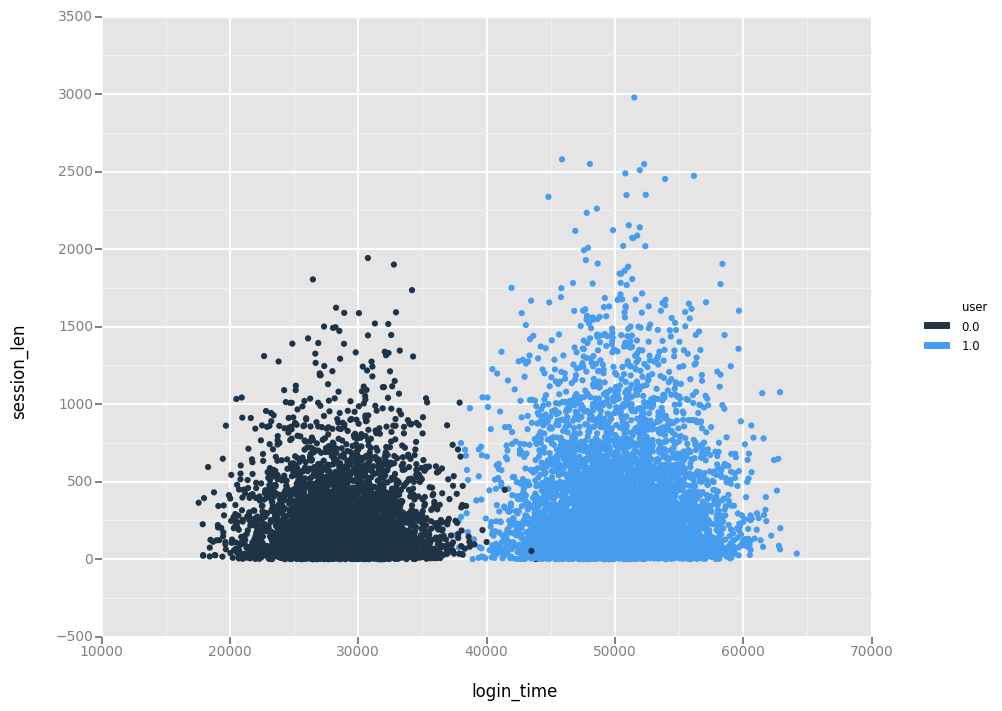

<ggplot: (8782959795961)>

In [42]:
gg.ggplot(gg.aes(x='login_time', y='session_len', color='user'), data=df) + gg.geom_point()

In [43]:
irf = IsoRandForest(random_seed=12345)

In [44]:
irf.fit(example_data)

In [31]:
irf.anom_scores[0:20]

array([ 0.71144593,  0.71694709,  0.73314218,  0.58322427,  0.58322427,
        0.58412344,  0.58322427,  0.58367368,  0.58322427,  0.58322427,
        0.58322427,  0.58322427,  0.58322427,  0.58322427,  0.58322427,
        0.58322427,  0.58479872,  0.58322427,  0.58322427,  0.58322427])

In [32]:
iTree = IsoRandForest.IsoTree(20)
iTree.fitTree(example_data)

In [33]:
iTree.findDepth(example_data[1,:])

11

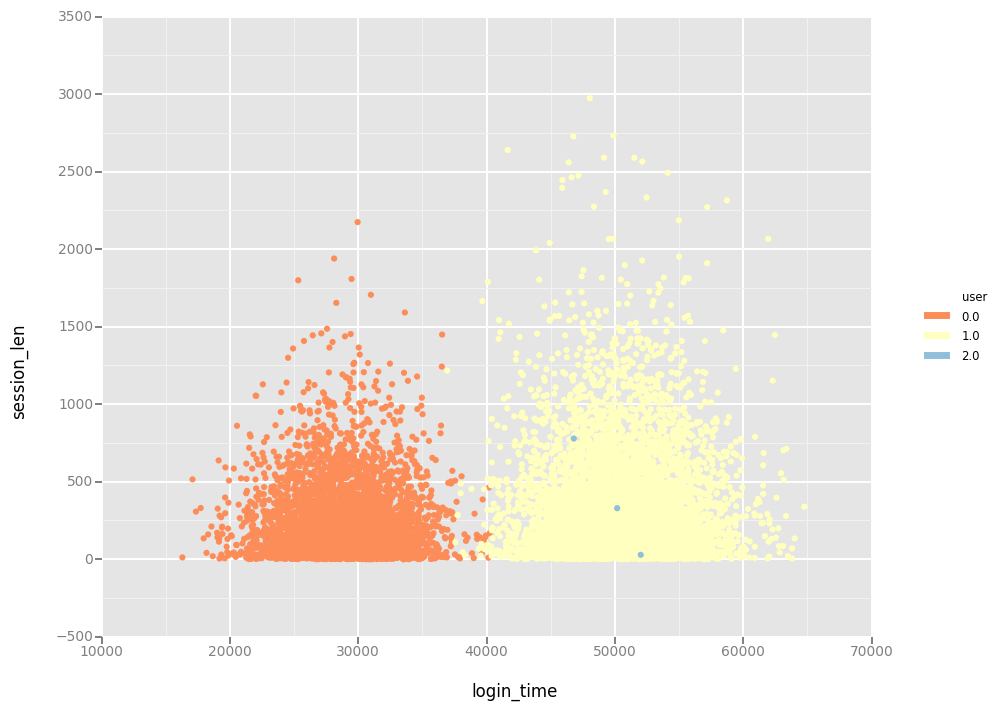

<ggplot: (8782968422161)>


In [34]:
df.loc[0:2,'user'] = 2
df['user'] = df['user'].apply(lambda x: str(x))

g = gg.ggplot(gg.aes(x='login_time', y='session_len', color='user'), data=df) +\
    gg.geom_point() +\
    gg.scale_color_brewer(type='div', palette='RdYlBu')
print g